## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [2]:
import networkx as nx
nx.__version__

'2.1'

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid_and_edges
import numpy.linalg as LA
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham

%matplotlib inline 

In [60]:
plt.rcParams['figure.figsize'] = 12, 12

In [61]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [62]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [128]:
# Static drone altitude (metres)
drone_altitude = 10
safety_distance = 5

In [129]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

888


Plot the edges on top of the grid along with start and goal locations.

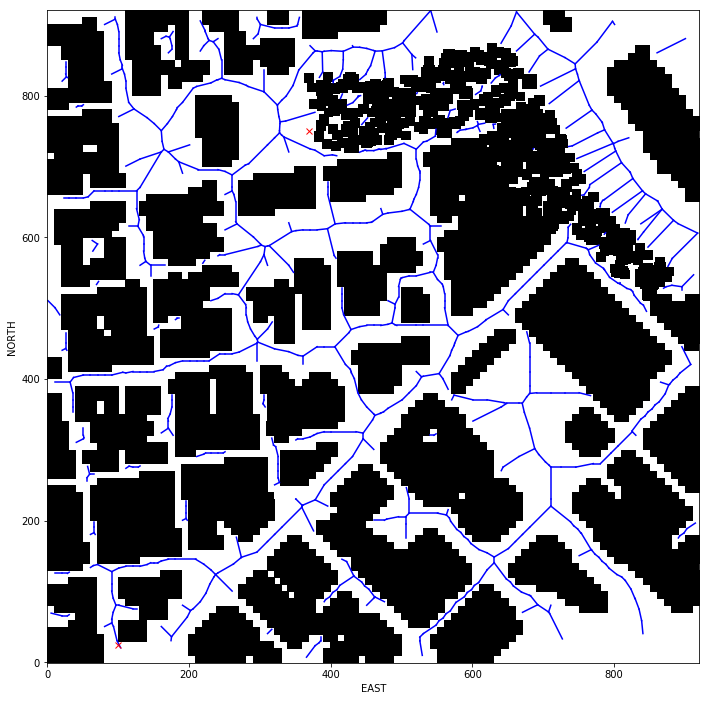

In [130]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [131]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()

for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [132]:
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n1) - np.array(n2))

def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

### TODO: Write your solution!

[our solution](/notebooks/Graph-Search-Solution.ipynb)

In [133]:
def closest_point(p1, graph):
    
    dist = 10000
    cp = None
    
    for node in graph.nodes:
        d = LA.norm(np.array(p1) - np.array(node))
        if d < dist:
            dist = d
            cp = node
    
    return cp

In [134]:
start_ne_g = closest_point(start_ne, G)
goal_ne_g = closest_point(goal_ne, G)

print(start_ne_g)
print(goal_ne_g)

(20.7611, 103.26850000000002)
(725.1152660107783, 370.76846)


In [135]:
path, cost = a_star(G, heuristic, start_ne_g, goal_ne_g)
print(len(path))

Found a path.
101


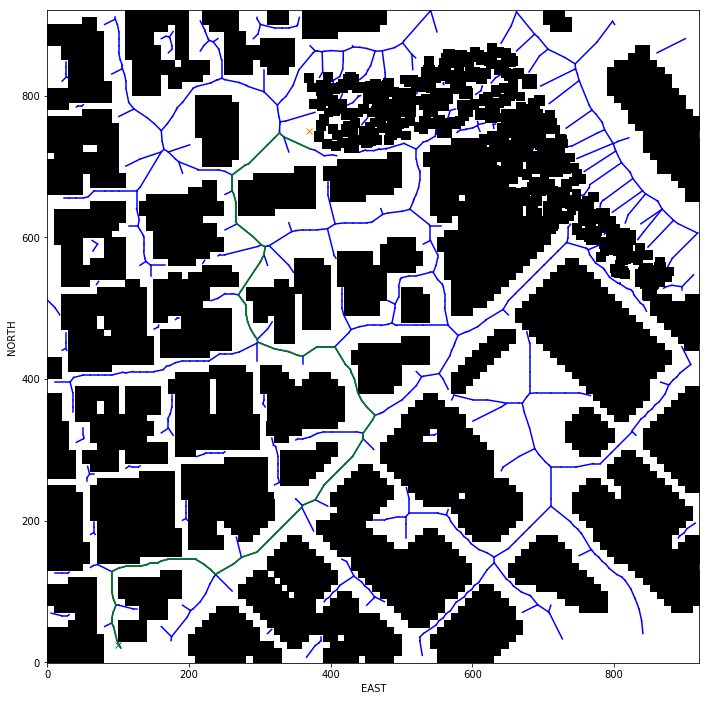

In [136]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')


for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [137]:
def prune_path_bres(path, gridd, goal):
    
    pruned_path = [p for p in path]
    i = 0
    
    while i < len(pruned_path) - 2:
        p1 = pruned_path[i]
        p2 = pruned_path[i+2]
        k = 0
        
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        #print(cells)
        
        for c in cells:
            k += gridd[c]
            #print(k)
            
        if k > 0:
            i += 1
        else:
            pruned_path.remove(pruned_path[i+1])
        
    pruned_path.append(goal)
    
    return pruned_path    

In [138]:
pruned_path = prune_path_bres(path, grid, goal_ne)
print(len(pruned_path))

16


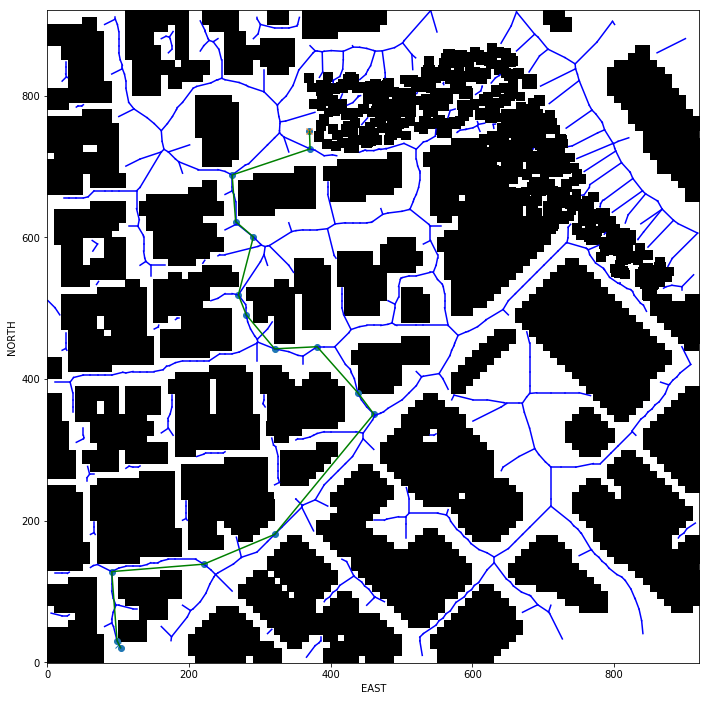

In [139]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')


for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()